In [1]:
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math

In [2]:
def drop_redundant_features(data):
    #find columns with high percentage of zeroes
    find_zeroes = data.columns[(data == 0).any()]
    num = (data[find_zeroes] == 0).sum()
    per_zeros = round(num/data.shape[0],2)

    #find features that has more than 90% zeroes
    features_with_zeroes = per_zeros[per_zeros>=0.80].index

    #Remove columns
    data.drop(features_with_zeroes,axis=1,inplace=True)

    #find columns with high percentage of NA
    find_na = data.isna().any()
    columns_na = data[data.columns[find_na]]
    na = columns_na.isna().sum()
    per_na = round(na/data.shape[0],2)

    #find features that has more than 90% NA
    features_with_NA = per_na[per_na>=0.80].index

    #Remove columns
    data.drop(features_with_NA,axis=1,inplace=True)

    return data

In [3]:
def replaceNARows(data):
    #Find string and number types with NA
    # na = data.isna().any()
    # na_columns = data[data.columns[na]]
    # numeric_info = na_columns._get_numeric_data().isna().sum()
    # string_features = [x for x in na_columns if x not in na_columns._get_numeric_data().columns]
    # string_info = data[string_features].isna().sum()
    # print(numeric_info)
    # print("=================")
    # print(string_info)

    #Replace Numerical NA with average value
    data['LotFrontage'] = data['LotFrontage'].fillna(data['LotFrontage'].mean())
    data['BsmtFinSF1'] = data['BsmtFinSF1'].fillna(data['BsmtFinSF1'].mean())
    # data['BsmtFinSF2'] = data['BsmtFinSF2'].fillna(data['BsmtFinSF2'].mean())
    data['BsmtUnfSF'] = data['BsmtUnfSF'].fillna(data['BsmtUnfSF'].mean())
    data['TotalBsmtSF'] = data['TotalBsmtSF'].fillna(data['TotalBsmtSF'].mean())
    data['MasVnrArea'] = data['MasVnrArea'].fillna(data['MasVnrArea'].median())
    data['GarageYrBlt'] = data['GarageYrBlt'].fillna(0)
    data['GarageCars'] = data['GarageCars'].fillna(0)
    data['GarageArea'] = data['GarageArea'].fillna(0)
    data['BsmtFullBath'] = data['BsmtFullBath'].fillna(0)

    #Replace String NA with 'None'
    data['MSZoning'] = data['MSZoning'].fillna(data['MSZoning'].mode()[0])
    data['Utilities'] = data['Utilities'].fillna(data['Utilities'].mode()[0])
    data['Exterior1st'] = data['Exterior1st'].fillna(data['Exterior1st'].mode()[0])
    data['Exterior2nd'] = data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0])
    data['Electrical'] = data['Electrical'].fillna(data['Electrical'].mode()[0])
    data['KitchenQual'] = data['KitchenQual'].fillna(data['KitchenQual'].mode()[0])
    data['Functional'] = data['Functional'].fillna(data['Functional'].mode()[0])
    data['SaleType'] =data['SaleType'].fillna(data['SaleType'].mode()[0])

    data['MasVnrType'] = data['MasVnrType'].fillna('None')
    data['BsmtQual'] = data['BsmtQual'].fillna('None')
    data['BsmtCond'] = data['BsmtCond'].fillna('None')
    data['BsmtExposure'] = data['BsmtExposure'].fillna('None')
    data['BsmtFinType1'] = data['BsmtFinType1'].fillna('None')
    data['BsmtFinType2'] = data['BsmtFinType2'].fillna('None')
    data['FireplaceQu'] = data['FireplaceQu'].fillna('None')
    data['GarageType'] = data['GarageType'].fillna('None')
    data['GarageFinish'] = data['GarageFinish'].fillna('None')
    data['GarageQual'] = data['GarageQual'].fillna('None')
    data['GarageCond'] = data['GarageCond'].fillna('None')
    # data['Fence'] = data['Fence'].fillna('None')

    return data

In [4]:
def feature_discovery(data,output,k):
    train = pd.concat([data,output],sort=False, axis=1)
    corrMatrix = train.corr()
    
    ## Russell v1
#     redundunt_feature_to_drop = ['GarageCars', '1stFlrSF','YearRemodAdd','BsmtQual_Ex','TotRmsAbvGrd']
#     data.drop(redundunt_feature_to_drop,axis=1,inplace=True)
#     # print(data.shape[1])
#     correlationMatrix = data.corr()
#     cols = correlationMatrix.nlargest(k, 'SalePrice')['SalePrice'].index
    
    ## Russell v2
    redundunt = []
    for i in corrMatrix:
        for j in corrMatrix:
            if(i != j and i != 'SalePrice' and j != 'SalePrice'):
                if(corrMatrix[i][j] >= 0.90):
                    redundunt.append(j)

    train.drop(redundunt,axis=1,inplace=True)
    new_correlationMatrix = train.corr()

    cols = new_correlationMatrix.nlargest(k, 'SalePrice')['SalePrice'].index

    #Plot Heatmap
#     f, ax = plt.subplots(figsize=(14, 10))
#     sns.heatmap(data[cols].corr(), vmax=.8, square=True)
#     plt.xticks(rotation=45)
#     plt.yticks(rotation=45)
#     plt.show()

    #Plot individual correlation
    # data.plot(x='GrLivArea',y='SalePrice',kind='scatter')
    # plt.show()

    #Print indexes with outlier
    # print(data.loc[data.GarageArea>3, ['SalePrice']])
    # print("=====================")
    # print(data.loc[data.GrLivArea>4, ['SalePrice']])
    # print("=====================")
    # print(data.loc[data.TotalBsmtSF>4, ['SalePrice']])

    return cols

In [5]:
## Step 1: Import CSV files
trainX = pd.read_csv('trainX.csv')
trainY = pd.read_csv('trainY.csv')
testX = pd.read_csv('testX.csv')
testY = pd.read_csv('testY.csv')

In [6]:
# ## Step 2: Check for any Null or NaN
# headers = trainX.mean().to_dict()

# # for i in headers:
# #     headers[i] = 0

# trainX = trainX.fillna(headers)
# trainX = trainX.fillna('None')

# testX = testX.fillna(headers)
# testX = testX.fillna('None')

# # na = trainX.isna().any()

# # for i, val in na.iteritems():
# #     if (val == True):
# #         print(i)

In [7]:
## Step 3: Convert any non-numerical input features into one hot encoding
#number of train
num_of_train = trainX.shape[0]
num_of_test = testX.shape[0]

# Combine training and test data
all_data = pd.concat([trainX, testX], sort=False).reset_index(drop=True)
print('Number of features (original): %d' %all_data.shape[1])

# Drop redundant (Russell)
all_data = drop_redundant_features(all_data)
print('Number of features (drop redundant features): %d' %all_data.shape[1])

# Replace NA rows (Russell)
all_data = replaceNARows(all_data)

# Getting dummy categorical values
all_data = pd.get_dummies(all_data)
print('Number of features (after one-hot encoding): %d' %all_data.shape[1])

# Seperate Training and Testing data
trainX = all_data.iloc[:num_of_train,:]
testX = all_data.iloc[num_of_train:,:]

print('Number of train rows: %d' %trainX.shape[0])
print('Number of test rows: %d' %testX.shape[0])

# trainX = pd.get_dummies(trainX)
# testX = pd.get_dummies(testX)

Number of features (original): 79
Number of features (drop redundant features): 67
Number of features (after one-hot encoding): 277
Number of train rows: 1022
Number of test rows: 438


In [8]:
## Step 4: Normal Distribution all input features
trainX = (trainX - np.mean(trainX, axis=0)) / np.std(trainX, axis=0)
testX = (testX - np.mean(testX, axis=0)) / np.std(testX, axis=0)

In [9]:
## Step 5: Scale all targets (/1000)
# trainY /= 1000
# testY /= 1000

In [10]:
## Step 6: Get correlation matrix
def getCorrMat(k):
    train = pd.concat([trainX, trainY], sort=False, axis=1)
    corrMatrix = train.corr()

    cols = corrMatrix.nlargest(k+1, 'SalePrice')['SalePrice'].index

    f, ax = plt.subplots(figsize=(14, 10))
    sns.heatmap(train[cols].corr(), vmax=.8, square=True, annot=True)
    plt.title('Features: %d' %k)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.autoscale()
#     plt.savefig('corrmat_%d' %k, dpi=300)
    plt.show()
    
    return cols

In [11]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

def evaluate(xgbr, trainX_, testX_):
    testY_ = testY['SalePrice'].values
    ypred = xgbr.predict(testX_)

    scores = cross_val_score(xgbr, trainX_, trainY, cv=5)
    print("Mean cross-validation score: %.5f" % scores.mean())

    kfold = KFold(n_splits=10, shuffle=True)
    kf_cv_scores = cross_val_score(xgbr, trainX_, trainY, cv=kfold)
    print("K-fold CV average score: %.5f" % kf_cv_scores.mean())
    print()

    mse = mean_squared_error(testY_, ypred)
    print("Mean Square Error: %.5f" % mse)
    msep = 0
    print("Mean Square Error (%%): {:.5f}".format(msep))
    print()
    
    print("Root Mean Square Error: %.5f" % np.sqrt(mse))
    rmsle_ = rmsle(testY_, ypred)
    print("Root Mean Square Log Error: %.5f" %rmsle_)
    print()

    mae = np.mean(np.abs(testY_ - ypred))
    print("Mean Absolute Error: {:.5f}".format(mae))
    maep = np.mean(np.abs((testY_ - ypred) / testY_)) * 100
    print("Mean Absolute Error (%%): %.5f%%" % maep)
    
    return ypred, rmsle_

In [12]:
## Plot figures
def plotResults(ypred, k, rmsle_):
    x_ax = range(len(testY))
    plt.figure(1, figsize=(10, 7))
    plt.title('Features: %d, RMSLE: %.5f' %(k, rmsle_))
    plt.scatter(x_ax, testY, s=5, color="blue", label="Original")
    plt.plot(x_ax, ypred, lw=0.8, color="red", label="Predicted")
    plt.xlabel('Test Dataset')
    plt.ylabel('SalePrice')
    plt.legend()
    plt.autoscale()
#     plt.savefig('XGBoost_Versus_%d' %k, dpi=300)

    plt.figure(2, figsize=(10, 7))
    plt.title('Features: %d, RMSLE: %.5f' %(k, rmsle_))
    plt.scatter(ypred, testY, s=5, color="blue")
    plt.plot([testY.min(), testY.max()],[testY.min(), testY.max()], 'k--', lw=2)
    plt.xlabel('Predicted')
    plt.ylabel('Original')
#     plt.savefig('XGBoost_Scatter_%d' %k, dpi=300)
    plt.show()

Mean cross-validation score: 0.86849
K-fold CV average score: 0.88351

Mean Square Error: 665513115.24219
Mean Square Error (%%): 0.00000

Root Mean Square Error: 25797.54088
Root Mean Square Log Error: 0.13935

Mean Absolute Error: 17167.71695
Mean Absolute Error (%): 10.29702%


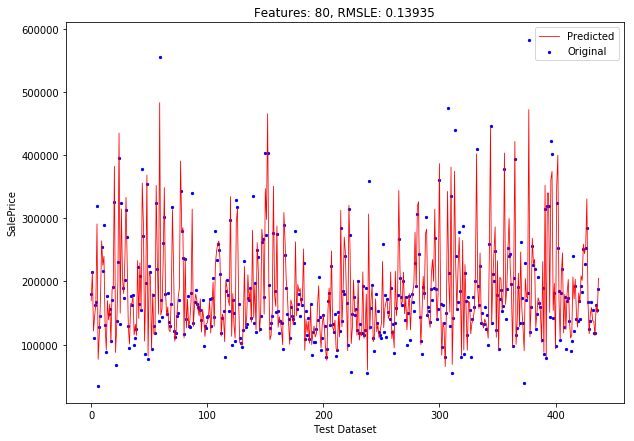

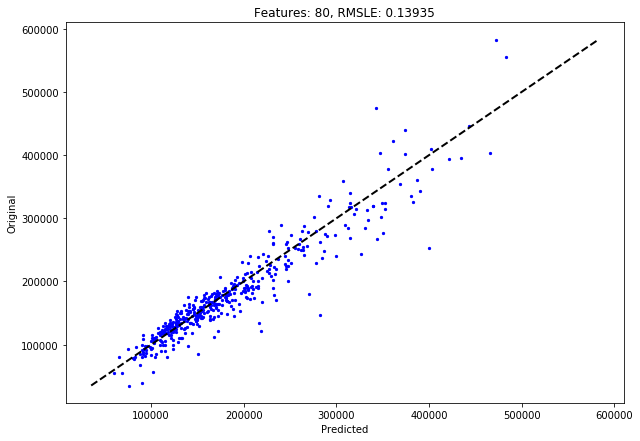

In [13]:
## Main Program
features = [80] #5, 10, 25, 50, 75, 100, 150, 200, 250, 300

for f in features:
    # Create the model
    xgbr = xgb.XGBRegressor(objective='reg:squarederror')
    
#     cols = getCorrMat(f)
    # Feature discovery (Russell)
    cols = feature_discovery(all_data, pd.concat([trainY, testY], sort=False).reset_index(drop=True), f)
    
    # Use only top f correlated features
    trainX_ = trainX[cols[1:]]
    testX_ = testX[cols[1:]]
    
    # Train the model
    xgbr.fit(trainX_, trainY)

    # Evaluate with test dataset
    ypred, rmsle_ = evaluate(xgbr, trainX_, testX_)
    plotResults(ypred, f, rmsle_)